<a href="https://colab.research.google.com/github/lucasocarvalhos/skimlit_project/blob/main/experiment_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone - SkimLit

### NLP model experiments to make reading medical abstracts easier.

> Dataset Paper <br>
https://arxiv.org/pdf/1710.06071.pdf

> Neural Network Paper <br>
https://arxiv.org/pdf/1612.05251.pdf

In [ ]:
# Check connection with GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-28 23:38:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-28 23:38:20 (43.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check files in the PubMed_20K dataset
import os

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess data

> Visualize, visualize, visualize...

In [ ]:
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filenames[0])

In [ ]:
train_lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
len(train_lines)

35135

Data woul be best represented as something like this:

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with etc',
  'total_lines': 11},
  ...
]

```

In [ ]:
def preprocess_txt(filename):
  """
  Returns a list of dicts of abstract line data.
  Takes in filename, reads it and sorts through each line, extracting things
  like the target label, text of the sentence, how many sentences are in the 
  abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename)

  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      
      for k, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_txt_split = abstract_line.split("\t")

        line_data["target"] = target_txt_split[0]
        line_data["text"] = target_txt_split[1].lower()
        line_data["line_number"] = k
        line_data["total_lines"] = len(abstract_line_split) - 1

        abstract_samples.append(line_data)

    else: 
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_txt(data_dir + "train.txt")
test_samples = preprocess_txt(data_dir + "test.txt")
val_samples = preprocess_txt(data_dir + "dev.txt")

CPU times: user 521 ms, sys: 73.3 ms, total: 595 ms
Wall time: 601 ms


In [ ]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [ ]:
train_samples[0:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [ ]:
train_df.head(8)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

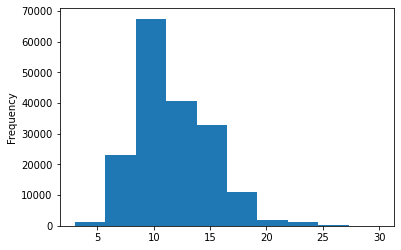

In [ ]:
train_df.total_lines.plot.hist();

## Get lists of sentences

In [ ]:
train_sentences = train_df["text"].to_list()
test_sentences = test_df["text"].to_list()
val_sentences = val_df["text"].to_list()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## One Hot Encode the labels



In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot.fit_transform(train_df["target"].values.reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df["target"].values.reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_df["target"].values.reshape(-1, 1))

In [ ]:
train_labels_one_hot[0:8]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

## Extract the labels and encode them into integers

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].values)
test_labels_encoded = label_encoder.transform(test_df["target"].values)
val_labels_encoded = label_encoder.transform(val_df["target"].values)

In [ ]:
train_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling experiments
## Trying a bunch of different models to see which one works best

In [ ]:
from helper_functions import calculate_results

## Model 0: Baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
]
)

# fit model
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate baseline
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.6760889712696941

In [ ]:
# make predictions on baseline
baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 67.60889712696941,
 'precision': 0.6750509747444058,
 'recall': 0.6760889712696941,
 'f1': 0.6351051244365337}

## Preparing data for Deep Sequence models
Vectorize and embed layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# how long is the average sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
np.mean(sent_lens)

26.178463580554173

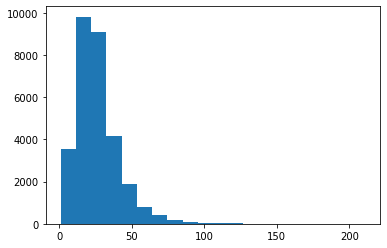

In [ ]:
plt.hist(sent_lens, bins=20);

In [ ]:
# how long of a sentence length cover 95% of the examples?
output_seq_len = np.percentile(sent_lens, 95)
output_seq_len

55.0

In [ ]:
# max length
np.max(sent_lens)

211

### Text Vectorizer

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
max_tokens = 68000 # this info is in the dataset paper

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=int(output_seq_len))

In [ ]:
# adapt text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# test text vectorizer into random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"Text: {target_sentence}")
print(f"\n Length of text: {len(target_sentence.split())}")
print(f"\n Vectorized text: \n {text_vectorizer([target_sentence])}")

Text: there was no increase in intraoperative and postoperative complications compared with the standard implantation technique using an ovd .

 Length of text: 19

 Vectorized text: 
 [[  64   10   33  178    5 1006    3  191  299   34    7    2  152  940
   410   56   31 9578    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# how many words in our training vocabulary
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"\n Most common words in vocab: \n {rct_20k_vocab[:5]}")
print(f"\n Most common words in vocab: \n {rct_20k_vocab[-5:]}")

Number of words in vocab: 24854

 Most common words in vocab: 
 ['', '[UNK]', 'the', 'and', 'of']

 Most common words in vocab: 
 ['aarhus', 'aai', 'aagg', 'aadenosine', 'aacr']


In [ ]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab),
                               output_dim=128, # different embed sizes in different numbers of parameters to train
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# show example of embedding
target_sentence = random.choice(train_sentences)

print(f"Text: {target_sentence}")
print(f"\n Vectorized text: \n {text_vectorizer([target_sentence])}")
print(f"\n Embedded text: \n {token_embed(text_vectorizer([target_sentence]))}")
print(f"\n Embedded sentence shape: \n {token_embed(text_vectorizer([target_sentence])).shape}")

Text: single randomized controlled trial .

 Vectorized text: 
 [[326  29 100  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

 Embedded text: 
 [[[ 0.0464134  -0.02332218  0.03389676 ... -0.03192961 -0.01021783
   -0.04930079]
  [ 0.00235873  0.01657065 -0.0241967  ... -0.01569752 -0.00683781
    0.01796963]
  [-0.03262828 -0.04660963 -0.01721399 ... -0.01926453  0.00777059
    0.03870836]
  ...
  [-0.01563598  0.04846504 -0.03421338 ... -0.03724254 -0.00826198
    0.03443598]
  [-0.01563598  0.04846504 -0.03421338 ... -0.03724254 -0.00826198
    0.03443598]
  [-0.01563598  0.04846504 -0.03421338 ... -0.03724254 -0.00826198
    0.03443598]]]

 Embedded sentence shape: 
 (1, 55, 128)


## Model 1: Conv1D with embeddings

### Creating datasets for better perfomance
Making sure data loads as fast as possible with tf.data API

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [ ]:
# prefetch increases perfomance as it uses data while preparing the next one
# tf.data.AUTOTUNE is to prefetch as many as the power computing can

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # it's not shuffled because order matters
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# create model
inputs = layers.Input(shape=(1,), 
                      dtype=tf.string)

text_vectors = text_vectorizer(inputs)

token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)

x = layers.GlobalAveragePooling1D()(x) # condense output from conv layer

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          3181312   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# fit model
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
94/94 [==============================] - 12s 106ms/step - loss: 1.4343 - accuracy: 0.3803 - val_loss: 1.3304 - val_accuracy: 0.4917
Epoch 2/3
94/94 [==============================] - 8s 88ms/step - loss: 1.1042 - accuracy: 0.5771 - val_loss: 0.9106 - val_accuracy: 0.6326
Epoch 3/3
94/94 [==============================] - 10s 106ms/step - loss: 0.8786 - accuracy: 0.6499 - val_loss: 0.7953 - val_accuracy: 0.6832


In [ ]:
# eval on whole val dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 13s 13ms/step - loss: 0.7970 - accuracy: 0.6867


[0.797008216381073, 0.6867138743400574]

In [ ]:
# make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

945/945 [==============================] - 11s 12ms/step


In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 68.67138885211175,
 'precision': 0.6437802500596761,
 'recall': 0.6867138885211175,
 'f1': 0.6567430891688938}

## Model 2: Feature Extraction with pretrained embeddings

Pretrained word embeddings: TF Hub Universal Sentence Encoder v4 (https://tfhub.dev/google/universal-sentence-encoder/4)

In [ ]:
import tensorflow_hub as hub

In [ ]:
# embedding from tf hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_train_sentence = random.choice(train_sentences)

print(f"Random sentece: {random_train_sentence} \n")

use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])

print(f"Sentece after embedding: \n {use_embedding_sentence[0][:30]} \n")
print(f"Embedding shape: \n {use_embedding_sentence.shape}")

Random sentece: participants made quarterly clinic visits for @ months . 

Sentece after embedding: 
 [ 0.03292433  0.01561741 -0.04549358  0.00857628 -0.04754442 -0.05159729
  0.02079747 -0.02173358 -0.08058405 -0.04336011  0.06550357  0.02467052
 -0.02755511  0.01969067 -0.04903416  0.03901407 -0.09349538 -0.00076704
 -0.06735143  0.05808042 -0.07904707  0.06851454 -0.01448293  0.00267322
  0.00362998  0.02044105 -0.0808377   0.05005224  0.04312206 -0.05099359] 

Embedding shape: 
 (1, 512)


In [ ]:
# feature extraction model

inputs = layers.Input(shape=[],
                      dtype=tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation="relu")(pretrained_embedding)

# more layers could be added

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
94/94 [==============================] - 6s 34ms/step - loss: 1.2667 - accuracy: 0.5027 - val_loss: 1.0334 - val_accuracy: 0.5961
Epoch 2/3
94/94 [==============================] - 3s 30ms/step - loss: 0.9318 - accuracy: 0.6376 - val_loss: 0.8721 - val_accuracy: 0.6659
Epoch 3/3
94/94 [==============================] - 4s 45ms/step - loss: 0.8716 - accuracy: 0.6676 - val_loss: 0.8276 - val_accuracy: 0.6812


In [ ]:
# evaluate on whole val dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.8308 - accuracy: 0.6804


[0.8307566046714783, 0.6804249882698059]

In [ ]:
# make predictions
model_2_preds = tf.argmax(model_2.predict(val_dataset), axis=1)

945/945 [==============================] - 16s 16ms/step


In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 68.0424996690057,
 'precision': 0.6774865404924147,
 'recall': 0.680424996690057,
 'f1': 0.672266826906849}

In [ ]:
baseline_results

{'accuracy': 67.60889712696941,
 'precision': 0.6750509747444058,
 'recall': 0.6760889712696941,
 'f1': 0.6351051244365337}

## Model 3: Conv1D with character embeddings

> **Token-level embedding**

`[I, love, Tensorflow] -> [ embeddings ]`

<br>

> **Character-level embedding**

`[I, , l, o, v, e, , T, e, n, s, o, r, f, l, o, w] -> [ embeddings ]`

### Create a character-level tokenizer

In [ ]:
# function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(random_train_sentence)

'p a r t i c i p a n t s   m a d e   q u a r t e r l y   c l i n i c   v i s i t s   f o r   @   m o n t h s   .'

In [ ]:
# apply function in whole dataset
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [ ]:
# average character length
chars_lens = [len(sentence) for sentence in train_sentences]

np.mean(chars_lens)

148.45996349759415

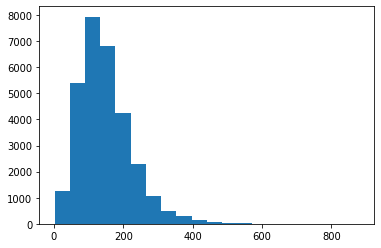

In [ ]:
plt.hist(chars_lens, bins=20);

In [ ]:
# character length that covers 95% of the sample
np.percentile(chars_lens, 95) # <- output sequence length

288.0

In [ ]:
# number of character tokens can be the number of letters in the alphabet
# plus the punctuation marks and digits
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 bc of space and <OOV> token

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=290,
                                    #standardize=None, # set None if want to leave punctuation
                                    name="char_vectorizer")

In [ ]:
# adapt character vectorizer 
char_vectorizer.adapt(train_chars)

In [ ]:
# check char vocab stats
char_vocab = char_vectorizer.get_vocabulary()

print(f"Number of different chars: {len(char_vocab)} \n")
print(f"5 most common chars: {char_vocab[:5]}")
print(f"5 least common chars: {char_vocab[-5:]}")

Number of different chars: 28 

5 most common chars: ['', '[UNK]', 'e', 't', 'i']
5 least common chars: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# create char-level embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # as seen in the original paper
                              mask_zero=True,
                              name="char_level_embedding")

In [ ]:
# create model
inputs = layers.Input(shape=(1,), dtype=tf.string) # shape is 1 bc it's taking one seq at a time

char_vectors = char_vectorizer(inputs)

char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_level_embedding (Embed  (None, 290, 25)          700       
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                           

### Load into tf.data for better perfomance

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# fit model
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
94/94 [==============================] - 5s 47ms/step - loss: 1.4615 - accuracy: 0.3723 - val_loss: 1.4399 - val_accuracy: 0.3381
Epoch 2/3
94/94 [==============================] - 4s 44ms/step - loss: 1.4030 - accuracy: 0.4495 - val_loss: 1.3643 - val_accuracy: 0.4591
Epoch 3/3
94/94 [==============================] - 4s 40ms/step - loss: 1.3281 - accuracy: 0.4644 - val_loss: 1.2511 - val_accuracy: 0.4887


In [ ]:
# evaluate on whole val dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 1.2445 - accuracy: 0.5012


[1.2445495128631592, 0.5011915564537048]

In [ ]:
# make predictions
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)

# model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

945/945 [==============================] - 11s 11ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 50.11915795048325,
 'precision': 0.4971105961958783,
 'recall': 0.5011915795048325,
 'f1': 0.4279456409850185}

## Model 4: Pretrained token embeddings + Character embeddings

1. Create a token-level embedding model (similar to `model_2`)
2. Create a character-level embedding model (similar to `model_3`)
3. Combine 1 and 2 with a concatenate
4. Build a series of output layers on top of 3
5. Construct a model which takes token and characters as inputs and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string) # empty list bc it's what tf hub USE expects

token_embeddings = tf_hub_embedding_layer(token_inputs)

token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(token_inputs, token_output)

In [ ]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embed(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
# 3. Concatenate previous models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [ ]:
# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)

combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
# 5. Construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer)

In [ ]:
# compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_4[0][0]']          

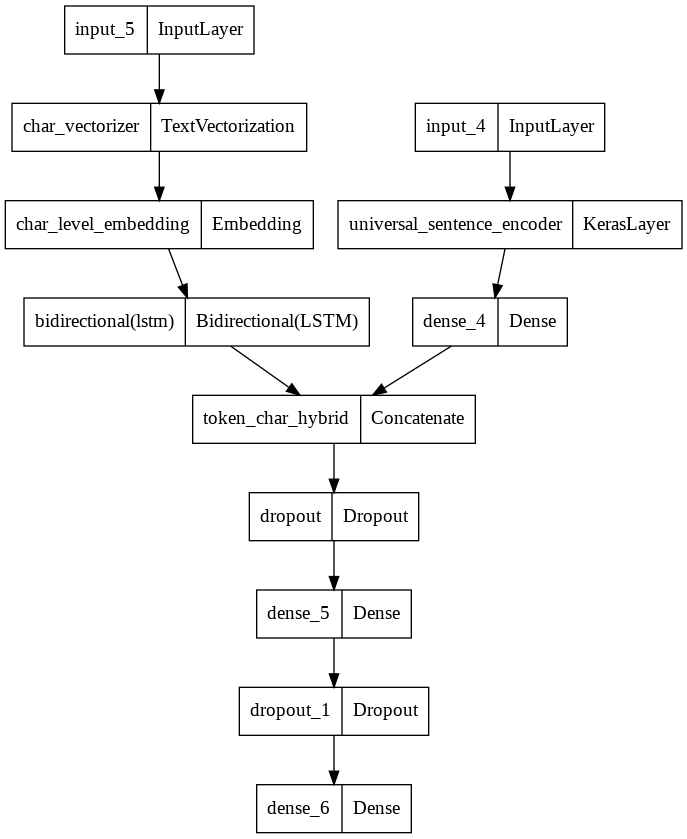

In [ ]:
# plot model illustration
from keras.utils import plot_model

plot_model(model_4)

### Create multi input fast loading data with tf.data

In [ ]:
# combine chars and tokens into a dataset
# train
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make label
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and label

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# val
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) 
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_char_token_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# fit model
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
94/94 [==============================] - 63s 507ms/step - loss: 1.3092 - accuracy: 0.4521 - val_loss: 1.0389 - val_accuracy: 0.5768
Epoch 2/3
94/94 [==============================] - 45s 485ms/step - loss: 0.9814 - accuracy: 0.6024 - val_loss: 0.8840 - val_accuracy: 0.6400
Epoch 3/3
94/94 [==============================] - 49s 519ms/step - loss: 0.9391 - accuracy: 0.6190 - val_loss: 0.8433 - val_accuracy: 0.6702


In [ ]:
# evaluate on whole val dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 73s 78ms/step - loss: 0.8430 - accuracy: 0.6698


[0.8429620265960693, 0.6697669625282288]

In [ ]:
# make preds
model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1)

# calculate results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 68s 68ms/step


{'accuracy': 66.97669800079439,
 'precision': 0.6903841353871719,
 'recall': 0.6697669800079439,
 'f1': 0.6578645576454786}

## Model 5: Pretrained token embeddings + Char embeddings + Positional embeddings

1. Create a token-level model
2. Create a character-level model
3. Create a model for line_number feature
4. Create a model for total_lines feature
5. Combine the outputs of 1 and 2
6. Combine the outputs of 3, 4 and 5
7. Combine the previous both outputs
8. Create an output layer to accept 7
9. Create model

### Create positional embeddings

In [ ]:
# we will use line numbers information from the data
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


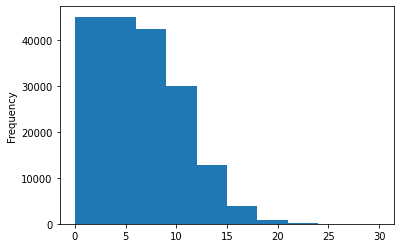

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# one hot encode line_number
# one hot encode only the sentences with less or equal than 15 lines
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

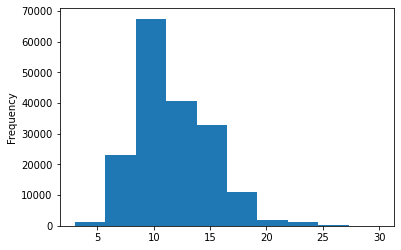

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# one hot encode total_lines
# one hot encode only the sentences with less or equal than 20 lines
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

> **Build Model**

In [ ]:
# 1. Token model
token_inputs = layers.Input(shape=[], dtype=tf.string)

token_embeddings = tf_hub_embedding_layer(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embed(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32)

x = layers.Dense(32, activation="relu")(line_number_inputs)

line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32)

y = layers.Dense(32, activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine the outputs of 1 and 2
combined_embeddings = layers.Concatenate()([token_model.output, 
                                            char_model.output])

# Add dropout
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with token and char embeddings
tribrid_embeddings = layers.Concatenate()([line_number_model.output, 
                                          total_lines_model.output,
                                          z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax")(tribrid_embeddings)

# 8. Put all together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

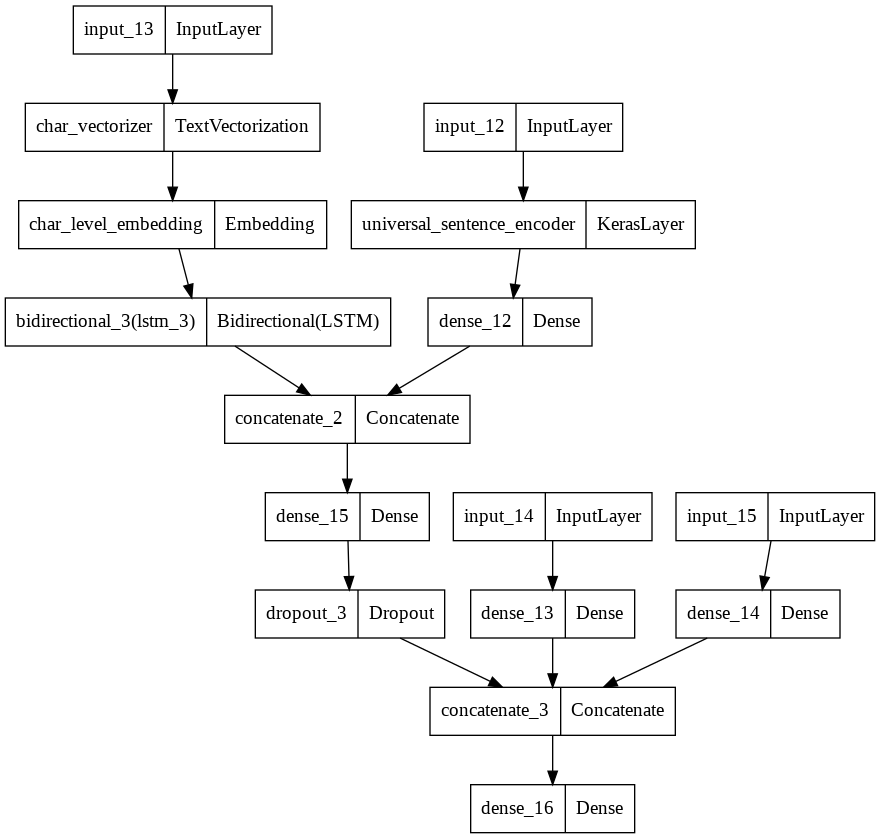

In [ ]:
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer="adam",
                metrics=["accuracy"])

### Load data with tf.data for better perfomance

In [ ]:
# create traning and val datasets with all four kinds of inputs
# train
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# val
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

> **FIT MODEL!!!**

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 208s 354ms/step - loss: 1.0953 - accuracy: 0.7235 - val_loss: 0.9809 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 189s 336ms/step - loss: 0.9662 - accuracy: 0.8155 - val_loss: 0.9491 - val_accuracy: 0.8248
Epoch 3/3
562/562 [==============================] - 222s 395ms/step - loss: 0.9494 - accuracy: 0.8249 - val_loss: 0.9382 - val_accuracy: 0.8311


In [ ]:
 # make predictions
 model_5_preds = tf.argmax(model_5.predict(val_char_token_pos_dataset, verbose=1), axis=1)

 # model results
 model_5_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_5_preds)
 model_5_results

945/945 [==============================] - 93s 98ms/step


{'accuracy': 83.29802727393088,
 'precision': 0.8318154922282414,
 'recall': 0.8329802727393089,
 'f1': 0.8320274742784708}

# Compare model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_token_char_embedding": model_4_results,
                                  "model_5_token_char_pos_embedding": model_5_results})

all_model_results = all_model_results.T
all_model_results.accuracy = all_model_results.accuracy/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.676089,0.675051,0.676089,0.635105
model_1_token_embedding,0.686714,0.643780,0.686714,0.656743
model_2_pretrained_token_embedding,0.680425,0.677487,0.680425,0.672267
model_3_char_embedding,0.501192,0.497111,0.501192,0.427946
model_4_token_char_embedding,0.669767,0.690384,0.669767,0.657865
model_5_token_char_pos_embedding,0.832980,0.831815,0.832980,0.832027


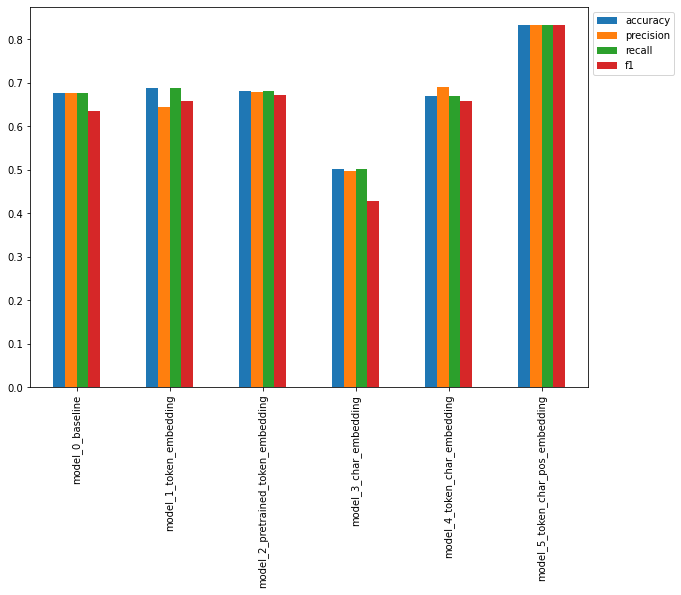

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

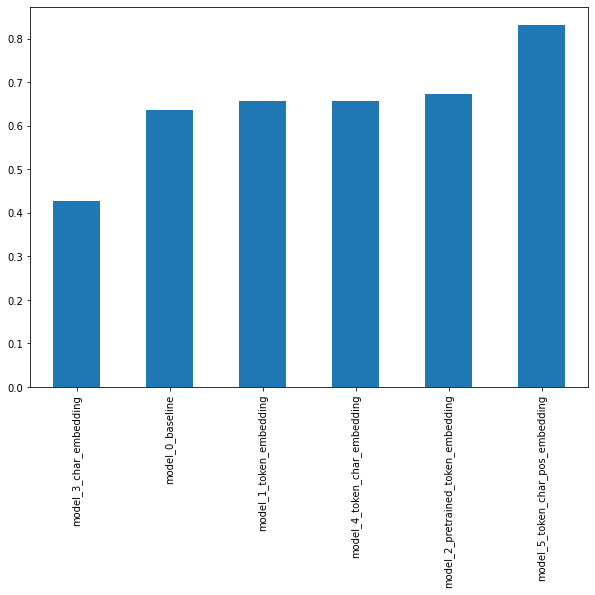

In [ ]:
# sort models by f1 scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

# Save model

In [ ]:
# model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in model
# loaded_model = tf.keras.models.load_model("/content/skimlit_tribrid_model")

# Next Step

## Train Tribrid Model in the 200k dataset